<a href="https://colab.research.google.com/github/sgparrot/sgparrot2021Lv1-1/blob/main/MNIST/MNIST_20210502_P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Classification

In [42]:
import os
import math
import argparse
import time
import random
import json

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Sequential
from tensorflow.data import Dataset

from copy import deepcopy

### for notebook users
%matplotlib inline

## Preprocessing & Inspecting

### Defining Dataloader
tensorflow.keras.utils.Sequence를 상속받아서 Dataloader라는 class를 생성

In [2]:
class Dataloader(Sequence):

    def __init__(self, x_set, y_set, batch_size, shuffle=False):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.shuffle=shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x = [self.x[i] for i in indices]
        batch_y = [self.y[i] for i in indices]

        return np.array(batch_x), np.array(batch_y)
    
    ### Epoch이 한 번 끝날 때마다 shuffle
    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

### Generating Datasets

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

X_train shape: (60000, 28, 28)
X_test shape: (10000, 28, 28)


### Preprocessing

In [4]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype("float32") / (2^8 - 1)
X_test = X_test.astype("float32") / (2^8 - 1)

y_train = to_categorical(y_train, 10)   # 변수화 필요
y_test = to_categorical(y_test, 10)     # 변수화 필요

In [5]:
train_loader = Dataloader(X_train, y_train, 128, shuffle=True)   # 변수화 필요
test_loader = Dataloader(X_test, y_test, 128, shuffle=False)     # 변수화 필요

### Dataset Inspecting

In [6]:
### 임시로 한 개의 minibatch를 돌려보는 상황

examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print("Target: {}".format(example_target.shape))
print("Data  : {}".format(example_data.shape))

Target: (128, 10)
Data  : (128, 28, 28, 1)


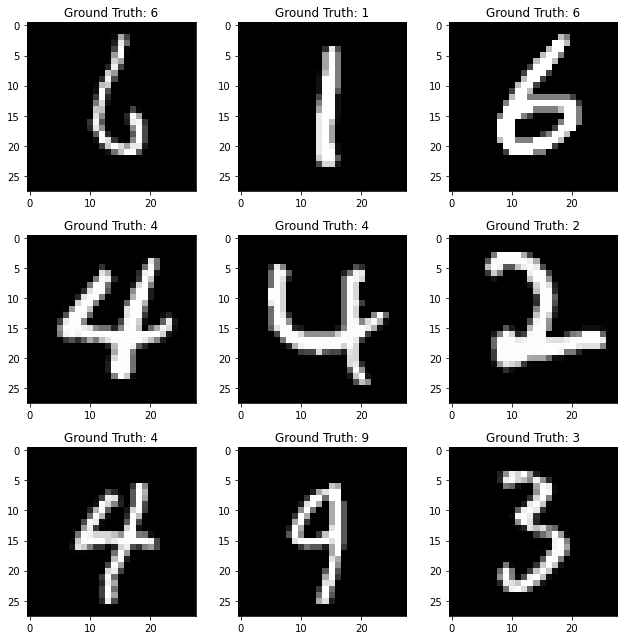

In [7]:
fig = plt.figure(figsize=(9, 9))

for i in range(9):
    plt.subplot(3, 3, 1 + i)
    plt.tight_layout()
    plt.imshow(tf.squeeze(example_data[i]), cmap="gray", interpolation="none")
    target = np.where(example_target[i]==1)[0]
    plt.title("Ground Truth: {}".format(int(target)))

plt.show()

## Modeling
CNN Modeling도 OOP로 구현하고 싶었으나, 아직 이해도가 부족한 것 같습니다.

In [8]:
def CNN(act, initial, dropout, use_bn):
    
    if act == "ReLU" or act == "relu":
        activation = "relu"
    elif act == "sigmoid":
        activation = "sigmoid"
    elif act == "tanh":
         activation = "tanh"
    elif act == "softmax":
        activation = "softmax"
    else:
        raise ValueError("Not a valid activation function.")
    
    if initial == "Xavier" or initial == "glorot":
        initializer = "glorot_uniform"
    elif initial == "he":
        initializer = "he_uniform"
    else:
        raise ValueError("Not a valid initializer.")
    
    model=Sequential()

    model.add(layers.Conv2D(filters=64, kernel_size=(5, 5), padding="Same", activation=activation, input_shape=(28, 28, 1)))
    if use_bn == True:
        model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(filters=64, kernel_size=(5, 5), padding="Same", activation=activation))
    if use_bn == True:
        model.add(layers.BatchNormalization())

    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Dropout(dropout))

    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding="Same", activation=activation))
    if use_bn == True:
        model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding="Same", activation=activation))
    if use_bn == True:
        model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(layers.Dropout(dropout))

    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding="Same", activation=activation))
    if use_bn == True:
        model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation=activation))
    if use_bn == True:
        model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout))

    model.add(layers.Dense(10, activation="softmax"))
    print(model.summary())
    
    return model

## Defining Callback Function

In [131]:
scheduler = lambda epoch: 0.001 - args.lr + 0.02 * (0.5**(1 + epoch))

lr_scheduler = callbacks.LearningRateScheduler(scheduler)

#lr_reduction = callbacks.ReduceLROnPlateau(monitor=args.monitor, patience=args.patience, verbose=1, factor=0.5, min_lr=1e-4)

filename = "checkpoint.json"
checkpoint = callbacks.ModelCheckpoint(filename, monitor=args.monitor, verbose=1,
                                       save_best_only=True, mode="auto")

earlystop = callbacks.EarlyStopping(monitor=args.monitor, min_delta=0,
                                    patience=args.patience,verbose=0, mode="auto",
                                    baseline=None, restore_best_weights=False)


for i in range(args.epoch):
    print(scheduler(1 + i))

callback_list = [lr_scheduler, earlystop]

0.00595
0.00345
0.0022
0.001575
0.0012625
0.00110625
0.001028125
0.0009890625
0.00096953125
0.000959765625
0.0009548828125
0.00095244140625
0.000951220703125
0.0009506103515625
0.00095030517578125
0.000950152587890625
0.0009500762939453125
0.0009500381469726562
0.0009500190734863281
0.000950009536743164


## Experiment

In [77]:
def experiment(args):
    
    model = CNN(act=args.act, initial=args.initializer,
                dropout=args.dropout, use_bn=args.use_bn)
    
    if args.optimizer == "SGD":
        optimizer = tf.keras.optimizers.SGD(learning_rate=args.lr)
    elif args.optimizer == "RMSprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=args.lr)
    elif args.optimizer == "Adam" or args.optimizer == "ADAM":
        optimizer = tf.keras.optimizers.Adam(learning_rate=args.lr)
    else:
        raise ValueError("Invalid Optimizer Choice.")
    
    model.compile(optimizer=optimizer, loss="categorical_crossentropy",
                  metrics=["accuracy"])
    
    hist = model.fit(X_train, y_train, batch_size=args.train_batch_size,
                 epochs=args.epoch, validation_split=0.2, verbose=1,
                 callbacks=callback_list)
    
    return hist, model

## Hyperparametrization
변수를 조절하는 부분입니다. 변수를 바꾸어가며 실험해보고 싶은 부분은 list로 목록을 만든 후 <br>
for문을 이용하여 실행하면 되고, 적절한 값을 찾은 변수는 직접 입력하면 됩니다.

In [170]:
parser = argparse.ArgumentParser()
args = parser.parse_args("")

### Model
# args.model_code = "VGG16"    # 실행할 모델 이름 (미구현)
args.in_dim = 1 * 28 * 28      # 파일 크기
# args.hidden_dim = 100        # MLP의 Hidden Dimension (미구현)
args.out_dim = 10              # 0부터 9까지, 총 10가지
args.act = "ReLU"              # Activation Function(ReLU, sigmoid, tanh, softmax 구현) -> ReLU 확정
#args.kernel_size = 3          # filter의 size

### Regulization
args.l2 = 5e-5                 # l2 정규화 alpha 값 -> 0.00005 확정
args.use_bn = True             # Batch Normalization 사용 여부 -> True 확정
args.dropout = 0.2             # dropout 비율 -> 0.2 확정
args.initializer = "Xavier"    # Initializer 설정(Xavier, he 구현) -> Xavier 확정

### Training & Test
args.optimizer = "RMSprop"     # Optimizer 설정(SGD, RMSprop, Adam 구현) -> RMSprop 확정
args.lr = 5e-5                 # Learning Rate -> 0.0005 확정
args.epoch = 20                # Epoch 횟수 -> 20 확정
args.train_batch_size = 2**7   # Training Batch Size
args.test_batch_size = 2**7    # Test Batch Size
args.monitor = "val_accuracy"  # loss, val_loss, accuracy, val_accuracy -> val_accuracy 확정
args.patience = 3              # callback function의 patience 값 (0 이상의 정수) -> 못 정함 ㅠ

### Experiment Variable

name_var1 = "monitor"
name_var2 = "patience"

list_var1 = ["val_accuracy"]
list_var2 = [0, 1, 2]

## Evaluation

In [167]:
model_list = []
hist_list = []

count = 0

for var1 in list_var1:
    for var2 in list_var2:
        
        setattr(args, name_var1, var1)   # args.name_var1 = var1과 같은 문법
        setattr(args, name_var2, var2)
        
        print(args)
        
        hist, model = experiment(deepcopy(args))
        
        model_list.append(model)
        hist_list.append(hist)

Namespace(act='ReLU', dropout=0.2, epoch=20, in_dim=784, initializer='Xavier', l2=5e-05, lr=5e-05, monitor='val_accuracy', optimizer='RMSprop', out_dim=10, patience=0, test_batch_size=128, train_batch_size=128, use_bn=True)
Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_327 (Conv2D)          (None, 28, 28, 64)        1664      
_________________________________________________________________
batch_normalization_390 (Bat (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_328 (Conv2D)          (None, 28, 28, 64)        102464    
_________________________________________________________________
batch_normalization_391 (Bat (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_132 (MaxPoolin (None, 14, 14, 64)        0         
___________________________

### Visualization for Train & Validation

In [12]:
def acc_loss_plot(hist):
    
    fit, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()
    
    loss_ax.plot(hist.history["loss"], "y", label="train_loss")
    loss_ax.plot(hist.history["val_loss"], "r", label="val_loss")
    loss_ax.set_xlabel("Epoch")
    loss_ax.set_ylabel("Loss")
    loss_ax.legend(loc = "upper left")
    
    acc_ax.plot(hist.history["accuracy"], "b", label="train_acc")
    acc_ax.plot(hist.history["val_accuracy"], "g", label="val_acc")
    acc_ax.set_ylabel("loss")
    acc_ax.legend(loc = "upper right")
    
    plt.show()

-monitor: val_accuracy, patience: 0
Train Loss: 0.004654334858059883, 	Train Accuracy: 0.9985833168029785
Validation Loss: 0.02567698433995247, 	Validation Accuracy: 0.9938333630561829


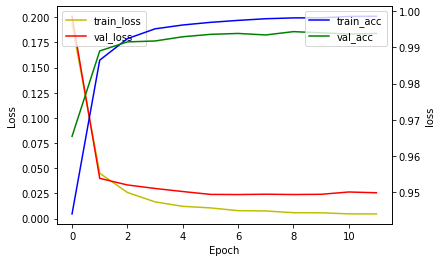

-monitor: val_accuracy, patience: 1
Train Loss: 0.0030621648766100407, 	Train Accuracy: 0.9988750219345093
Validation Loss: 0.03294134885072708, 	Validation Accuracy: 0.9936666488647461


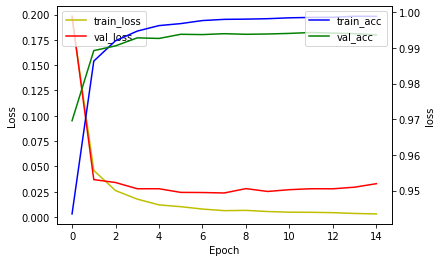

-monitor: val_accuracy, patience: 2
Train Loss: 0.0057403831742703915, 	Train Accuracy: 0.9982291460037231
Validation Loss: 0.025743603706359863, 	Validation Accuracy: 0.9942499995231628


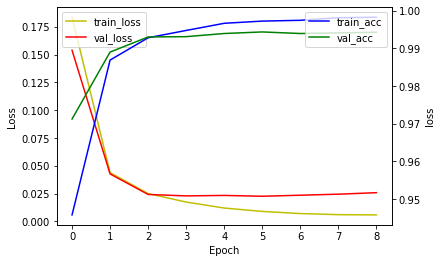

-monitor: val_accuracy, patience: 3
Train Loss: 0.0046670394949615, 	Train Accuracy: 0.9983541369438171
Validation Loss: 0.025515466928482056, 	Validation Accuracy: 0.9934999942779541


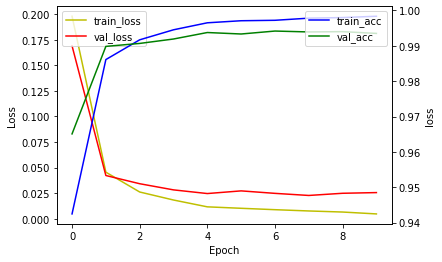

In [168]:
count = 0

for var1 in list_var1:
    for var2 in list_var2:
        
        print("-{0}: {1}, {2}: {3}"
              .format(name_var1, var1, name_var2, var2))
        
        print("Train Loss: {0}, \tTrain Accuracy: {1}"
              .format(hist_list[count].history["loss"][-1],
                     hist_list[count].history["accuracy"][-1]))
        print("Validation Loss: {0}, \tValidation Accuracy: {1}"
              .format(hist_list[count].history["val_loss"][-1],
                     hist_list[count].history["val_accuracy"][-1]))
        
        acc_loss_plot(hist_list[count])
        plt.show()
        
        count +=1

## Test

In [169]:
count = 0

for var1 in list_var1:
    for var2 in list_var2:
        
        print("-{0}: {1}, {2}: {3}"
              .format(name_var1, var1, name_var2, var2))
        
        score = model_list[count].evaluate(X_test, y_test, verbose=0)
        print("Test Loss: {}".format(score[0]))
        print("Test Accuracy: {}\n".format(score[1]))
        
        count += 1

-monitor: val_accuracy, patience: 0
Test Loss: 0.01808851584792137
Test Accuracy: 0.9957000017166138

-monitor: val_accuracy, patience: 1
Test Loss: 0.02080591954290867
Test Accuracy: 0.9955000281333923

-monitor: val_accuracy, patience: 2
Test Loss: 0.017041459679603577
Test Accuracy: 0.9962999820709229

-monitor: val_accuracy, patience: 3
Test Loss: 0.016809483990073204
Test Accuracy: 0.9952999949455261



## FINAL RESULT

In [23]:
hist, model = experiment(deepcopy(args))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 28, 28, 64)        1664      
_________________________________________________________________
batch_normalization_24 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 28, 28, 64)        102464    
_________________________________________________________________
batch_normalization_25 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 14, 14, 64)       

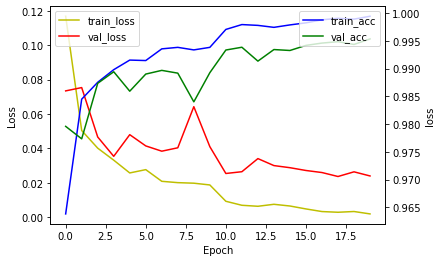

None


In [24]:
print("baseline accuracy")
print(acc_loss_plot(hist))

In [25]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test Loss: {}".format(score[0]))
print("Test Accuracy: {}".format(score[1]))

Test Loss: 0.01861541159451008
Test Accuracy: 0.9958000183105469


### Review

In [171]:
wrong_result = []

for i in range(0, len(y_test)):
    if predicted_labels[i] != test_labels[i]:
        wrong_result.append(i)

num_wrong = len(wrong_result)
sqrt_num_wrong = math.ceil(math.sqrt(num_wrong))

print("{0} data were not matched correctly.".format(num_wrong))

43 data were not matched correctly.


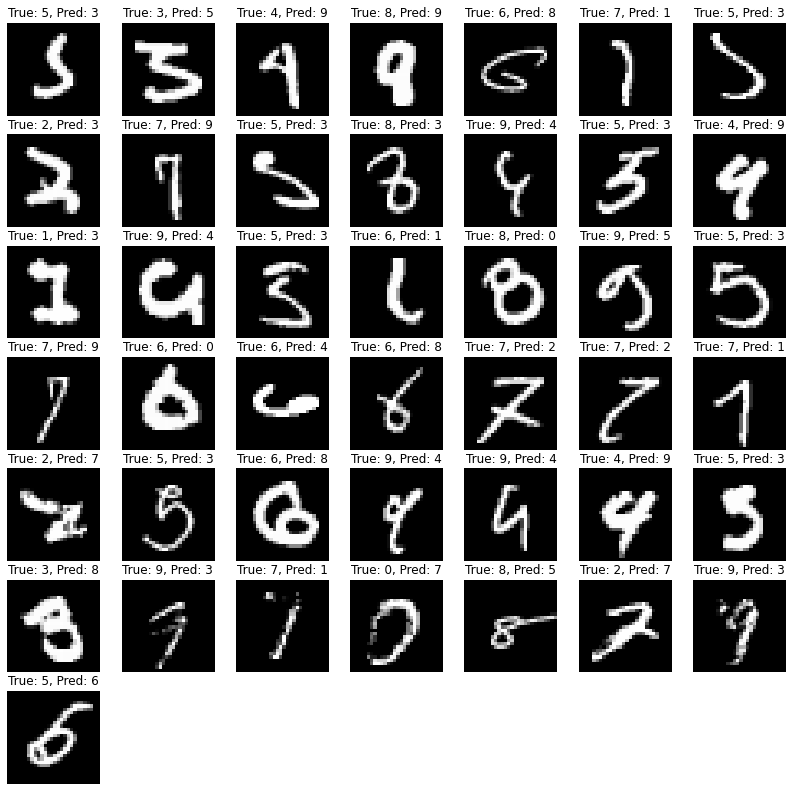

<Figure size 648x648 with 0 Axes>

In [173]:
#틀린 데이터 시각화 

plt.figure(figsize=(2 * sqrt_num_wrong, 2 * sqrt_num_wrong))

for i, j in enumerate(wrong_result):

    plt.subplot(sqrt_num_wrong, sqrt_num_wrong, i + 1)
    plt.imshow(tf.squeeze(X_test[j]), cmap = 'gray', interpolation='none')
    plt.title("True: {0}, Pred: {1}".format(test_labels[j],
                                            predicted_labels[j]))
    plt.axis('off')
    
plt.show()

fig = plt.figure(figsize=(9, 9))